In [1]:
# 1 — Imports
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

print("✅ Ready!")

c:\Users\Lenovo\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Ready!


In [ ]:
#  2 — Load Processed Data
df = pd.read_csv('outputs/processed_data.csv')

# Simple feature set: just basics
FEATURES = [
    # Basic features
    'year', 'month',
    # Categorical features (encoded)
    'admin1_enc', 'market_enc', 'category_enc', 'commodity_enc', 'unit_enc'
]

TARGET = 'price'

X = df[FEATURES]
y = df[TARGET]

print(f"Features shape : {X.shape}")
print(f"Number of features: {len(FEATURES)}")
print(f"Price range    : LKR {y.min():.2f} – {y.max():.2f}")
print(f"\nFeatures used in training:")
print(FEATURES)
X.head(3)

Features shape : (22364, 7)
Number of features: 7
Price range    : LKR 16.00 – 2550.00

Features used in training:
['year', 'month', 'admin1_enc', 'market_enc', 'category_enc', 'commodity_enc', 'unit_enc']


,year,month,admin1_enc,market_enc,category_enc,commodity_enc,unit_enc
0,2004,1,8,5,0,35,1
1,2004,2,8,5,0,35,1
2,2004,3,8,5,0,35,1


: 

In [ ]:
# 3 — Split Data
# Split into 60% train / 20% validation / 20% test
# Test set is held out completely — never seen during training

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Train:      {len(X_train):,} rows  (60%)")
print(f"Validation: {len(X_val):,} rows  (20%)")
print(f"Test:       {len(X_test):,} rows  (20%)")

Train:      13,418 rows  (60%)
Validation: 4,473 rows  (20%)
Test:       4,473 rows  (20%)


: 

In [ ]:
# 4 — Train XGBoost with Improved Hyperparameters

import numpy as np

def get_sample_weights(years):
    """
    Assigns higher weight to recent years.
    2023-2025 → weight 5  (most important, recent crisis prices)
    2020-2022 → weight 3  (economic crisis period)
    2015-2019 → weight 2  (moderate importance)
    before 2015 → weight 1 (least important, old cheap prices)
    """
    weights = np.ones(len(years))
    weights[years >= 2023] = 5.0
    weights[(years >= 2020) & (years < 2023)] = 3.0
    weights[(years >= 2015) & (years < 2020)] = 2.0
    return weights

# Get years from training data for weight calculation
train_years = X_train['year'].values
sample_weights = get_sample_weights(train_years)

print("Sample weight distribution:")
print(f"  Before 2015 : weight 1.0 → {(train_years < 2015).sum():,} rows")
print(f"  2015–2019   : weight 2.0 → {((train_years >= 2015) & (train_years < 2020)).sum():,} rows")
print(f"  2020–2022   : weight 3.0 → {((train_years >= 2020) & (train_years < 2023)).sum():,} rows")
print(f"  2023–2025   : weight 5.0 → {(train_years >= 2023).sum():,} rows")

# Improved hyperparameters for better accuracy
model = XGBRegressor(
    n_estimators=800,              # More trees for better fit
    max_depth=7,                    # Slightly deeper trees
    learning_rate=0.02,             # Slower, more careful learning
    subsample=0.85,                 # More data per tree
    colsample_bytree=0.85,          # More features per tree
    colsample_bylevel=0.9,
    gamma=1,                        # Regularization to prevent overfitting
    reg_alpha=0.1,                  # L1 regularization
    reg_lambda=1.0,                 # L2 regularization
    random_state=42,
    n_jobs=-1,
    verbosity=0,
    early_stopping_rounds=50        # Stop if no improvement for 50 rounds
)

# Pass sample_weight so recent years influence the model more
model.fit(
    X_train, y_train,
    sample_weight=sample_weights,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print("\n✅ Model trained with improved hyperparameters!")
print(f"   Best iteration: {model.best_iteration}")
print(f"   Trees used: {model.n_estimators}")

Sample weight distribution:
  Before 2015 : weight 1.0 → 652 rows
  2015–2019   : weight 2.0 → 967 rows
  2020–2022   : weight 3.0 → 523 rows
  2023–2025   : weight 5.0 → 11,276 rows

✅ Model trained with improved hyperparameters!
   Best iteration: 799
   Trees used: 800


: 

In [ ]:
# 5 — Evaluate the Model
# MAE  = average rupee error per prediction
# RMSE = like MAE but punishes large errors more heavily  
# R²   = 1.0 is perfect, 0.0 means no better than guessing the average

def evaluate(name, X, y):
    preds = model.predict(X)
    mae  = mean_absolute_error(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    r2   = r2_score(y, preds)
    print(f"{name:<12} | MAE={mae:7.2f} LKR | RMSE={rmse:7.2f} LKR | R²={r2:.4f}")
    return preds

print(f"{'Split':<12} | {'MAE':>14} | {'RMSE':>16} | R²")
print("-" * 58)
evaluate("Train",      X_train, y_train)
evaluate("Validation", X_val,   y_val)
evaluate("Test",       X_test,  y_test)

Split        |            MAE |             RMSE | R²
----------------------------------------------------------
Train        | MAE=  41.27 LKR | RMSE=  66.78 LKR | R²=0.9870
Validation   | MAE=  52.35 LKR | RMSE=  86.42 LKR | R²=0.9788
Test         | MAE=  51.57 LKR | RMSE=  83.87 LKR | R²=0.9791


array([  94.05177,  465.55   , 1313.9792 , ...,  824.3787 ,  834.156  ,
        724.92206], shape=(4473,), dtype=float32)

: 

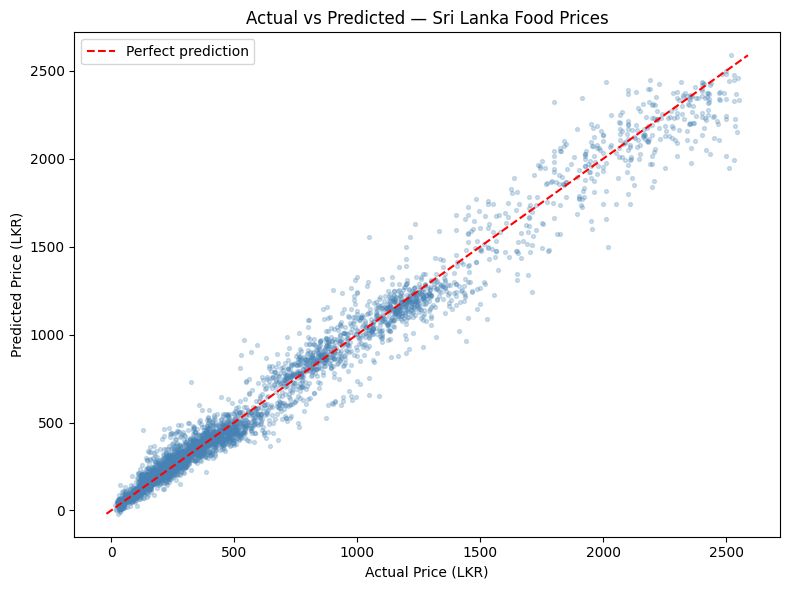

✅ Saved: outputs/actual_vs_predicted.png


: 

In [ ]:
# 6 — Plot Actual vs Predicted
# Points close to the red diagonal line = accurate predictions
test_preds = model.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, test_preds, alpha=0.25, color='steelblue', s=8)
lims = [min(y_test.min(), test_preds.min()), max(y_test.max(), test_preds.max())]
ax.plot(lims, lims, 'r--', linewidth=1.5, label='Perfect prediction')
ax.set_xlabel('Actual Price (LKR)')
ax.set_ylabel('Predicted Price (LKR)')
ax.set_title('Actual vs Predicted — Sri Lanka Food Prices')
ax.legend()
plt.tight_layout()
plt.savefig('outputs/actual_vs_predicted.png', dpi=150)
plt.show()
print("✅ Saved: outputs/actual_vs_predicted.png")

Calculating SHAP values... (takes ~1 minute)


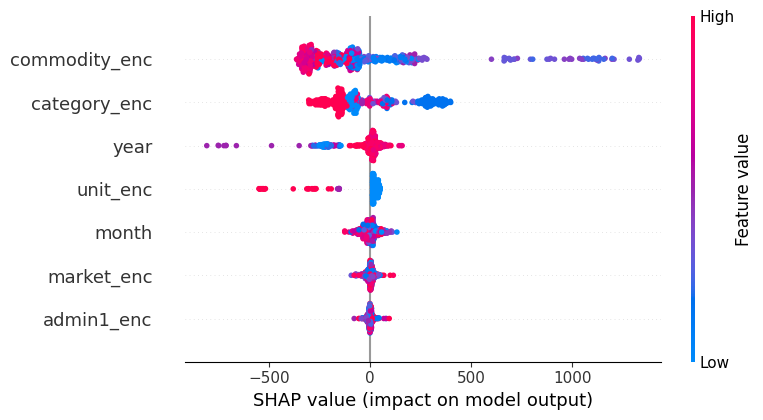

✅ Saved: outputs/shap_summary.png


: 

In [ ]:
#  7 — SHAP Analysis
# SHAP shows HOW MUCH each feature pushed the price up or down
# High positive SHAP = feature increased the predicted price
# High negative SHAP = feature decreased the predicted price

print("Calculating SHAP values... (takes ~1 minute)")

explainer   = shap.TreeExplainer(model)
X_sample    = X_test.sample(500, random_state=42)
shap_values = explainer.shap_values(X_sample)

# Beeswarm plot — one dot per prediction per feature
shap.summary_plot(shap_values, X_sample, feature_names=FEATURES, show=False)
plt.tight_layout()
plt.savefig('outputs/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Saved: outputs/shap_summary.png")

In [ ]:
#  8 — Save Model
# Save trained model
with open('models/xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("✅ Saved: models/xgb_model.pkl")
print("\n🎉 Training complete! Now open app.py and run the frontend.")

✅ Saved: models/xgb_model.pkl

🎉 Training complete! Now open app.py and run the frontend.


: 